# BigClam Community Affiliation Implementation in Pyspark

The BigClam (Big Cluster Affiliation Model) is a community affiliation/detection model for detecting overlapping communities within large and complex networks. This algorithm was developed by Jure Leskovec at Stanford and published in this [paper](https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf). What sets BigClam apart from other traditional community affiliation methods is that each node in a network can belong to multiple communities/clusters, whereas most assume that a node only belongs to one or another.

In BigClam, each node is represented by an affiliation vector, which represents the strength or likelihood that the node belongs to that cluster. The method operates by maximizing the likelihood of observing the given network structure based on the affiliation vectors.

There is a great explanation of the algorithm by Jure Leskcovec on youtube [here](https://www.youtube.com/watch?v=SHcVHrsgj8w).

Without getting too into the details of why the model makes sense, which is full of probability, bayesian, and graph theory - and is explained very well in the paper and video, the main function we are trying to maximize is:

$$
\mathcal{L}(F_u) = \sum_{v \in N(u)} - \log(1 - \exp(F_u F_v^T)) + \sum_{v \notin N(u)} (F_u F_v^T)
$$

Where F is the affiliation matrix, u and v are vertices in a graph G(V,E), and (u,v) in E represents all neighbors of u and (u,v) not in E are all non neighbors of u.

Given this function, we can calculate its derivative with respect to Fu as: 

$$
\frac{\partial \mathcal{L}(F)}{\partial F_u} = \sum_{v \in N(u)} \frac{\exp(-F_u F_v^T)}{1 - \exp(-F_u F_v^T)} + \sum_{v \notin N(u)} F_v
$$

Now we can use gradient descent/ascent to maximize the loss function. As this is written, both equations are quite computationally expensive, but we can make it extremely fast by factoring and substituting less expensive parts of the equation back in. For example, as explained in the paper, the time to compute each nodes' L(F_u) and its gradient is O(n) where n is the number of nodes. But we can simplify the time to O(N(u)) using the following equation:

$$
\sum_{v \notin N(u)} F_v = \sum_{v} F_v - F_u - \sum_{v \in N(u)} F_v
$$


By storing sum(F_v) we can compute both the loss and gradient in time O(N(u)). This is done using the following equation:

$$
\sum_{v \notin N(u) \cup \{u\}} F_u F_v^T = F_u \sum_{v \notin N(u) \cup \{u\}} F_v^T = F_u \left(\sum_{v \in A(u)} F_v^T - F_u^T - \sum_{v \in N(u)} F_v^T \right)
$$

## Implemenation in Pyspark

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Let's create an example adjacency matrix in pyspark by importing the adjacency matrix of the movies example in Neo4j. I've created a function that will store the adjacency matrix in an rdd with the schema (i, (j, value)) where value will be 1 if there is an edge between nodes i and j. The matrix is symetrical.

In [5]:
from src.pyspark_eigensolver import *
from src.samplematrix import create_sample_adj_matrix, create_default_neo4j_spark_session

# Set the URI, username, and password for the Neo4j database
uri = 'bolt://localhost:7687'
user = 'neo4j'
password = 'password'
    
spark = create_default_neo4j_spark_session(uri, user, password)

adjacency_rdd = create_sample_adj_matrix(spark, uri, user, password)

n = get_n(adjacency_rdd)

23/04/21 14:25:40 WARN Utils: Your hostname, Michaels-MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 10.202.7.119 instead (on interface en0)
23/04/21 14:25:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/Users/michaelroth/miniforge3/envs/golden_torch/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/michaelroth/.ivy2/cache
The jars for the packages stored in: /Users/michaelroth/.ivy2/jars
org.neo4j#neo4j-connector-apache-spark_2.12 added as a dependency
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-a3d38388-fa13-47f9-9dd7-4dd478618f6b;1.0
	confs: [default]
	found org.neo4j#neo4j-connector-apache-spark_2.12;5.0.0_for_spark_3 in central
	found org.neo4j#neo4j-connector-apache-spark_2.12_common;5.0.0 in central
	found org.neo4j.driver#neo4j-java-driver;4.4.9 in central
	found org.reactivestreams#reactive-streams;1.0.3 in central
	found org.apache.xbean#xbean-asm6-shaded;4.10 in central
	found org.neo4j#neo4j-cypher-dsl;2020.1.4 in central
	found org.apiguardian#apiguardian-api;1.1.0 in central
	found graphframes#graphframes;0.8.0-spark3.0-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 589ms :: artifacts dl 45ms
	:: modules in use:
	

23/04/21 14:25:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
/Users/michaelroth/miniforge3/envs/golden_torch/lib/python3.10/site-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


Here we define a few custom functions that will be used in the pyspark map functions.

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def reduce_add(a,b):
    return a+b

def map_transpose(x):
    return (x[1][0], (x[0], x[1][1]))

def remove_i(x):
    return x[1]

In [7]:
def bigclam_pyspark(adj_matrix_rdd, k, epsilon=1e-8, max_iter=500, learning_rate_start=5e-4, num_partitions=1, print_loss=False):

    learning_rate = learning_rate_start

    # Get the number of nodes in the graph
    n = get_n(adj_matrix_rdd)
    
    sc = adj_matrix_rdd.context

    # Initialize the affiliation matrix F with random values
    # Each element of F is a tuple (i, (j, value)) where i is the node index, j is the community index, and value is a random float
    f_rdd = sc.parallelize([(i, (j, np.random.rand())) for i in range(n) for j in range(k)])
    
    # Normalize each row of F
    f_rdd = f_rdd.join(f_rdd.mapValues(remove_i).reduceByKey(reduce_add)).mapValues(lambda x: (x[0][0], x[0][1] / (x[1]**2)**.5)).cache()

    # Create a list of neighbors for each node
    neighbors = adj_matrix_rdd.mapValues(lambda x: x[0]).groupByKey().mapValues(list).cache()

    for j in range(max_iter):
        start = time.time()
        if j > 0:
            loss_prev = loss
    
        # Compute the sum of F_v for all nodes v
        sum_f = f_rdd.map(remove_i).reduceByKey(reduce_add).cache()

        # Join neighbors with F
        f_neighbors = neighbors.flatMapValues(lambda x: x) \
                        .map(lambda x: (x[1], x[0])) \
                        .join(f_rdd).cache()
        
        # Compute dot products between F_u and F_v for all neighbors (u, v)
        dot_prods =  f_neighbors \
                .map(lambda x: (((x[1][1][0], x[1][0]), (x[0], x[1][1][1])))) \
                .join(f_rdd.map(lambda x: ((x[1][0], x[0]), x[1][1]))) \
                .map(lambda x: ((x[0][1], x[1][0][0]), (x[1][0][1]*x[1][1]))) \
                .reduceByKey(reduce_add) \
                .sortByKey() \
                .map(lambda x: (x[0][0], (x[0][1], x[1]))) \
                .repartition(num_partitions).cache()

        # Compute the sum of F_v for all neighbors of u, weighted by (1 - sigmoid of dot product)
        neighbor_sums = f_neighbors \
                .map(lambda x: ((x[0], x[1][0]), x[1][1])) \
                .join(dot_prods.map(lambda x: ((x[0], x[1][0]), x[1][1]))) \
                .map(lambda x: ((x[0][0], x[1][0][0]), x[1][0][1] * (1 - sigmoid(x[1][1])))) \
                .reduceByKey(reduce_add) \
                .repartition(num_partitions)

        # Compute the sum of F_v for all nodes v that are neighbors of u
        sum_f_neighbors = f_neighbors \
                .map(lambda x: ((x[0], x[1][1][0]), x[1][1][1])) \
                .reduceByKey(reduce_add) \
                .repartition(num_partitions)

        # Compute the sum of F_v for all nodes v that are not neighbors of u
        non_neighbor_sums = f_rdd.map(map_transpose).join(sum_f) \
                                .map(lambda x: ((x[1][0][0], x[0]), (x[1][0][1], x[1][1]))) \
                                .join(sum_f_neighbors) \
                                .map(lambda x: (x[0], ( x[1][0][1] - x[1][0][0] - x[1][1]))) \
                                .repartition(num_partitions)
        
        # Compute the gradients for F_u by taking the difference between neighbor_sums and non_neighbor_sums
        grads = neighbor_sums.join(non_neighbor_sums) \
                            .map(lambda x: (x[0], (x[1][0] - x[1][1]))) \
                            .repartition(num_partitions)

        # Compute the loss function for non-neighbors
        non_neighbor_dot = f_rdd.map(map_transpose) \
                .join(sum_f) \
                .map(lambda x: (x[1][0][0], x[1][0][1] * x[1][1])) \
                .join(dot_prods.map(remove_i).reduceByKey(reduce_add)) \
                .mapValues(lambda x: x[0] - x[1]).map(remove_i).reduce(reduce_add)

        # Compute the loss function
        loss = dot_prods.map(lambda x: np.log(1 - np.exp(-max(epsilon, x[1][1])))).reduce(reduce_add) - non_neighbor_dot

        # Check for convergence or update the learning rate based on the change in loss
        if j > 0:
            loss_change = loss_prev - loss

            loss_percent = loss_change / loss

            learning_rate = np.minimum(loss_percent*1e-2, learning_rate)

            if abs(loss_change) < .001 or loss_change > 0:
                    if print_loss:
                        print(j, loss_percent)
                    break

        if j > 0 and j % 1 == 0 and print_loss:
                print(loss_percent, learning_rate)

        # Update F_u using the computed gradients
        f_rdd = f_rdd.map(lambda x: ((x[0], x[1][0]), x[1][1])) \
                    .join(grads) \
                    .mapValues(lambda x: np.maximum(x[0] + learning_rate * x[1], epsilon)) \
                    .map(lambda x: (x[0][0], (x[0][1], x[1]))) \
                    .repartition(num_partitions).cache()
        
    return f_rdd

In [8]:
# Set the number of communities to 5
k = 5

# Set the epsilon value for numerical stability
epsilon = 1e-8

# Compute the delta value based on epsilon
delta = np.sqrt(-np.log(1-epsilon))

# Get the Spark context from the adjacency matrix RDD
sc = adjacency_rdd.context

In [9]:
# Run the implementation
%time f_test = bigclam_pyspark(adjacency_rdd, k=k)

CPU times: user 1.14 s, sys: 572 ms, total: 1.71 s
Wall time: 41.3 s


## Finding the optimal K

This function, get_optimal_k_pyspark, is used to find the optimal number of communities (k) in the BigClam algorithm using the Bayesian Information Criterion (BIC). 

In [10]:
def get_optimal_k_pyspark(adj_matrix_rdd, k_min=2, k_max=10, max_iter=500, epsilon=1e-8, learning_rate_start=5e-4, num_partitions=1):
    # Set the range of k values to try, from k_min to k_max
    k_range = range(k_min, k_max+1)
    
    # Get the number of nodes in the graph
    num_nodes = get_n(adj_matrix_rdd)
    
    # Get the number of edges in the graph
    num_edges = adjacency_rdd.count()
    
    # Initialize a list to store BIC scores for each value of k
    bic_scores = []
    
    # Iterate through the range of k values
    for k in k_range:
        
        # Run the BigClam algorithm for the given value of k
        f = bigclam_pyspark(adj_matrix_rdd=adj_matrix_rdd, k=k, max_iter=max_iter, epsilon=epsilon, num_partitions=num_partitions)
        
        # Compute the dot product of F and F.T
        f_dot_fT = matrix_matrix_dot_product(f.map(map_transpose), f, num_partitions)
        
        # Define the loss function
        loss_fn = lambda x: np.log(1 - np.exp(-x))
        
        # Compute the loss for the current value of k
        loss = f_dot_fT.map(lambda x: loss_fn(x[1][1])).reduce(reduce_add)
        
        # Compute the BIC score for the current value of k
        bic = -2*loss + k*num_nodes*np.log(num_edges)
        
        # Append the BIC score to the list
        bic_scores.append(bic)
        print(k, bic)
        
    # Find the optimal k value that minimizes the BIC score
    optimal_k = k_range[np.argmin(bic_scores)]
    
    return optimal_k, bic_scores

In [11]:
k_min = 2
k_max = 20

%time optimal_k, bic_scores = get_optimal_k_pyspark(adjacency_rdd, k_min=k_min, k_max=k_max)

2 377881.2606814312


3 253012.6685808517


4 238059.97671448614


5 237533.06044005058


6 234001.82241620467


7 233103.39514506265


8 232707.82837263955


9 233652.94504383727


10 236187.64922762653


11 235315.61575425172


12 235638.48993821666


13 236788.2988145158


14 238738.00010172083


15 238621.9398547037


16 240721.27416037754


17 240991.19870544306


18 242875.4619165314


19 242959.44788074007


20 243069.01255679026
CPU times: user 20.6 s, sys: 11.1 s, total: 31.8 s
Wall time: 9min 46s


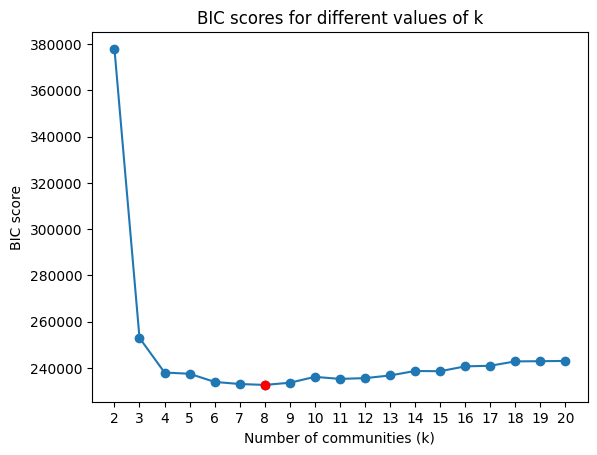

In [12]:
# Plot the BIC scores for each k
plt.plot(range(k_min, k_max+1), bic_scores, '-o')

# Add a dot for the optimal k value
plt.plot(optimal_k, min(bic_scores), 'ro')
plt.xticks(range(k_min, k_max+1))
# Label the plot
plt.xlabel('Number of communities (k)')
plt.ylabel('BIC score')
plt.title('BIC scores for different values of k')
plt.show()

In [13]:
names = spark.read.format("org.neo4j.spark.DataSource") \
    .option("url", uri) \
    .option("authentication.basic.username", user) \
    .option("authentication.basic.password", password) \
    .option('query','''MATCH (n)
WHERE labels(n)[0] in ['Movie', 'Person']
WITH id(n) as id, CASE
                    WHEN n:Movie THEN n.title
                    WHEN n:Person THEN n.name
                    END as name
RETURN id, name''') \
    .load()

In [14]:
names_df = names.select('name').to_pandas_on_spark()

/Users/michaelroth/miniforge3/envs/golden_torch/lib/python3.10/site-packages/pyspark/sql/dataframe.py:3313: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(
/Users/michaelroth/miniforge3/envs/golden_torch/lib/python3.10/site-packages/pyspark/pandas/__init__.py:49: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [27]:
# Convert f to a numpy array
f_np = rdd_to_numpy(bigclam_pyspark(adjacency_rdd, k=optimal_k), n_j=optimal_k)

In [33]:
# Set a threshold for community membership. Higher threshold == less affiliation to community
threshold = .15

print(f'Communities for k={optimal_k}')

# Iterate through each community from 0 to optimal_k - 1
for i in range(optimal_k):
    # Print the current community index
    print(f'Community: {i+1}')
    
    # Select the nodes that have a community affiliation score greater than the threshold for the current community (i)
    # and display their corresponding names from the names_df DataFrame
    display(names_df.loc[np.where(f_np[:, i] > threshold)[0]])

Communities for k=8
Community: 1


name
14          Taylor Hackford
22         Cuba Gooding Jr.
24               J.T. Walsh
27               Rob Reiner
30           Kelly McGillis
52       As Good as It Gets
62   Snow Falling on Cedars
66              Scott Hicks
78   Joe Versus the Volcano
84              Bruno Kirby
106             Halle Berry
113              Ron Howard
116             Stephen Rea
118               Ben Miles
133       Patricia Clarkson
145                 Twister
152  Something's Gotta Give
165             Paul Blythe

Community: 2


name
2          Carrie-Anne Moss
4              Hugo Weaving
21                Noah Wyle
25           James Marshall
26        Christopher Guest
33             Tom Skerritt
59            Werner Herzog
61             Vincent Ward
69           Dave Chappelle
78   Joe Versus the Volcano
80              Nathan Lane
90            Orlando Jones
101          Takeshi Kitano
107           Jim Broadbent
110            Ian McKellen
112            Paul Bettany
128          The Green Mile
144             Bill Paxton
148               Cast Away
156          Chris Columbus
165             Paul Blythe
175                   Joker

Community: 3


name
4                       Hugo Weaving
14                   Taylor Hackford
26                 Christopher Guest
30                    Kelly McGillis
32                   Anthony Edwards
41                          Jay Mohr
42                       Bonnie Hunt
52                As Good as It Gets
56              What Dreams May Come
58                     Max von Sydow
62            Snow Falling on Cedars
64                         Rick Yune
72                       Nora Ephron
81              When Harry Met Sally
96                      Mike Nichols
119                      Speed Racer
127                    Naomie Harris
139                            Hoffa
150  One Flew Over the Cuckoo's Nest
153                     Diane Keaton

Community: 4


name
1              Keanu Reeves
2          Carrie-Anne Moss
5            Andy Wachowski
29                  Top Gun
34                 Meg Ryan
36                 Jim Cash
46              Stand By Me
48            Corey Feldman
49              Wil Wheaton
50              John Cusack
67          You've Got Mail
69           Dave Chappelle
96             Mike Nichols
100         Johnny Mnemonic
101          Takeshi Kitano
116             Stephen Rea
117               John Hurt
126          Ninja Assassin
131            Sam Rockwell
146  Philip Seymour Hoffman
161                 Madonna

Community: 5


name
7             Joel Silver
9     The Matrix Reloaded
11   The Devil's Advocate
29                Top Gun
53             Helen Hunt
56   What Dreams May Come
64              Rick Yune
69         Dave Chappelle
75           Bill Pullman
83          Carrie Fisher
95           The Birdcage
117             John Hurt
137         Michael Sheen
145               Twister
154          Nancy Meyers

Community: 6


name
16             Tom Cruise
22       Cuba Gooding Jr.
39          Kelly Preston
54           Greg Kinnear
57      Annabella Sciorra
58          Max von Sydow
59          Werner Herzog
79   John Patrick Stanley
80            Nathan Lane
90          Orlando Jones
92             RescueDawn
97             Unforgiven
116           Stephen Rea
133     Patricia Clarkson
142             Apollo 13
147           Jan de Bont
156        Chris Columbus
157  Charlie Wilson's War
158         Julia Roberts

Community: 7


name
2          Carrie-Anne Moss
6            Lana Wachowski
8               Emil Eifrem
42              Bonnie Hunt
44        Jonathan Lipnicki
47            River Phoenix
57        Annabella Sciorra
61             Vincent Ward
114          V for Vendetta
127           Naomie Harris
147             Jan de Bont
152  Something's Gotta Give
161                 Madonna
164          Penny Marshall
167        Jessica Thompson
171            Sun-kyun Lee

Community: 8


name
66      Scott Hicks
84      Bruno Kirby
95     The Birdcage
98   Richard Harris
103           Ice-T
114  V for Vendetta
119     Speed Racer
135     Frost/Nixon
145         Twister
164  Penny Marshall
172    Yeo-jeong Jo